# Testset Generation for RAG

In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [ ]:
from langchain_groq import ChatGroq
from ragas.llms import LangchainLLMWrapper

groq_llm = ChatGroq(model="llama3-8b-8192")
evaluator_llm = LangchainLLMWrapper(groq_llm)

## Query types in RAG

#### Single-Hop Query

- A single-hop query is a straightforward question that requires retrieving information from a single document or source to provide a relevant answer.

#### Multi-Hop Query

- A multi-hop query involves multiple steps of reasoning, requiring information from two or more sources

## Knowledge Graph Creation

Given that we want to manufacture different types of queries from the given set of documents, our major challenge is to identify the right set of chunks or documents to enable LLMs to create the queries.

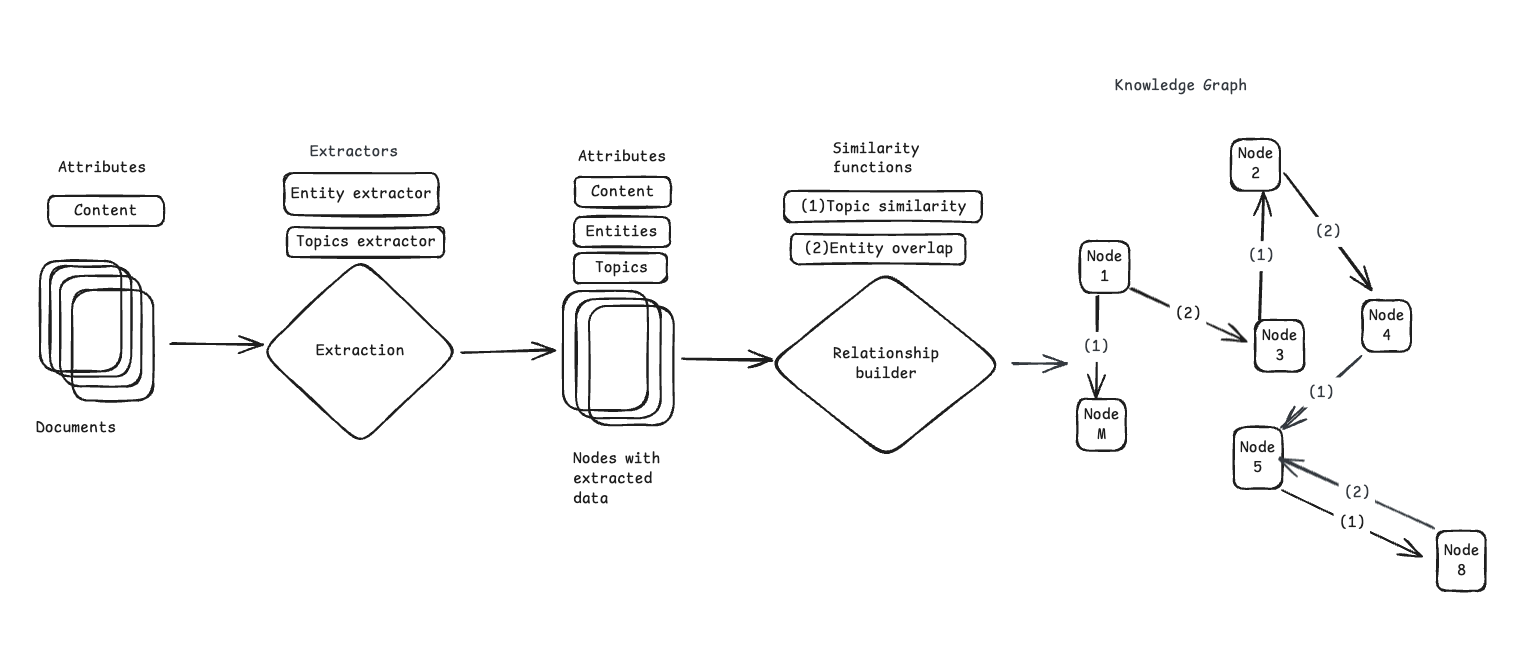

#### Document Splitter

- The documents are chunked to form hierarchial nodes. The chunking can be done by using different splitters.

In [ ]:
from ragas.testset.graph import Node

sample_nodes = [Node(
    properties={"page_content": "Einstein's theory of relativity revolutionized our understanding of space and time. It introduced the concept that time is not absolute but can change depending on the observer's frame of reference."}
),Node(
    properties={"page_content": "Time dilation occurs when an object moves close to the speed of light, causing time to pass slower relative to a stationary observer. This phenomenon is a key prediction of Einstein's special theory of relativity."}
)]

sample_nodes

#### Extractors

- Different extractors are used to extract information from each nodes that can be used to establish the relationship between the nodes.

In [ ]:
from ragas.testset.transforms.extractors import NERExtractor

extractor = NERExtractor()
output = [await extractor.extract(node) for node in sample_nodes]
output[0]

In [ ]:
_ = [node.properties.update({key:val}) for (key,val), node in zip(output, sample_nodes)]
sample_nodes[0].properties

#### Relationship builder

- The extracted information is used to establish the relationship between the nodes

In [ ]:
from ragas.testset.graph import KnowledgeGraph
from ragas.testset.transforms.relationship_builders.traditional import JaccardSimilarityBuilder

kg = KnowledgeGraph(nodes=sample_nodes)
rel_builder = JaccardSimilarityBuilder(property_name="entities", key_name="PER", new_property_name="entity_jaccard_similarity")
relationships = await rel_builder.transform(kg)
relationships

#### Transforms

- All of the components used to build the knowledge graph can be combined into a single transform that can be applied to the knowledge graph to build the knowledge graph. 
- Transforms is made of up of a list of components that are applied to the knowledge graph in a sequence. 
- It can also handle parallel processing of the components. 
- The apply_transforms method is used to apply the transforms to the knowledge graph.

In [ ]:
from ragas.testset.transforms import apply_transforms

transforms = [
    extractor,
    rel_builder
    ]

apply_transforms(kg,transforms)

In [ ]:
from ragas.testset.transforms.extractors import KeyphrasesExtractor, NERExtractor
from ragas.testset.transforms import Parallel, apply_transforms

transforms = [
    Parallel(
        KeyphrasesExtractor(),
        NERExtractor()
    ),
    rel_builder
]

apply_transforms(kg= kg, transforms= transforms)

### Scenario Generation

Each Scenario in Test set Generation is a combination of following parameters.

- Nodes : The nodes that are used to generate the query
- Query Length : The length of the desired query, it can be short, medium or long, etc.
- Query Style : The style of the query, it can be web search, chat, etc.
- Persona : The persona of the user, it can be Senior Engineer, Junior Engineer, etc.

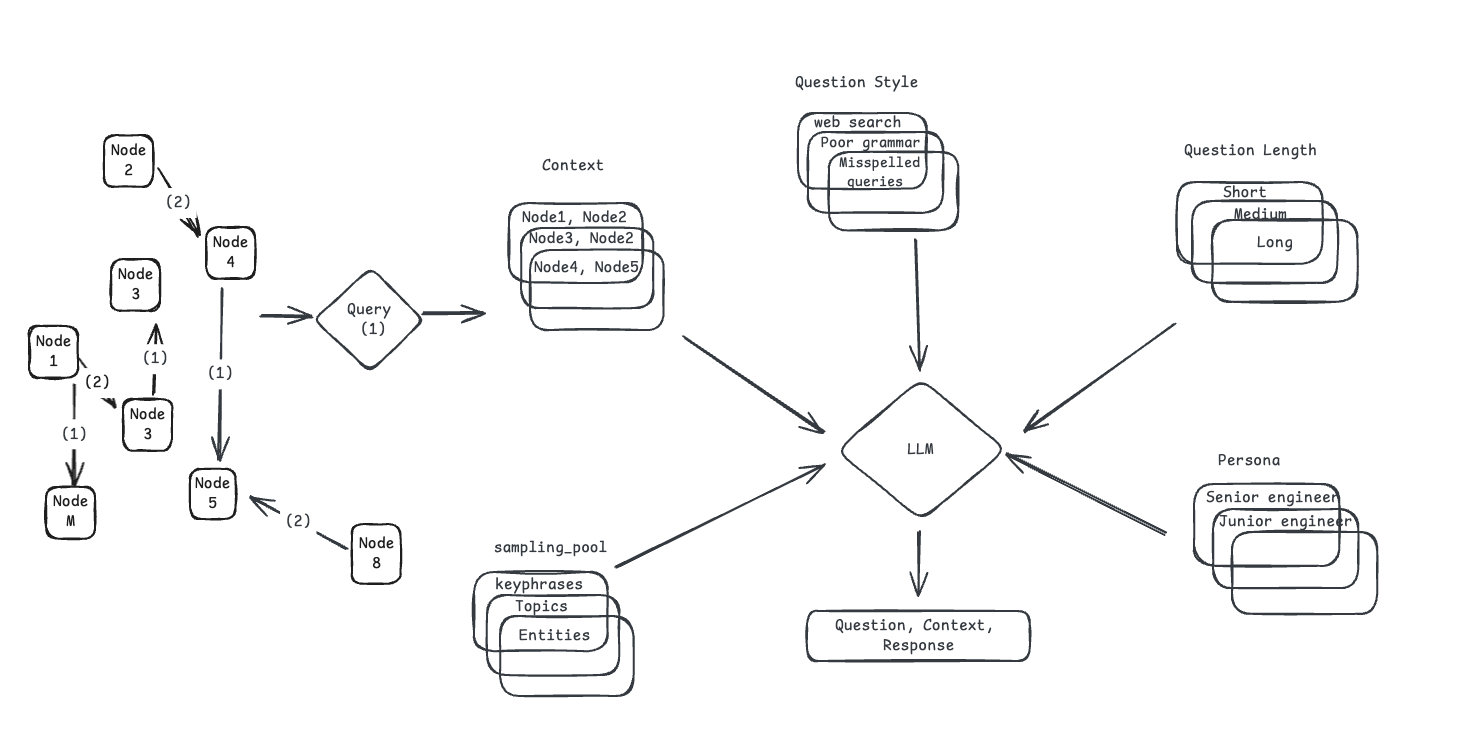

#### Query Synthesizer

- The QuerySynthesizer is responsible for generating different scenarios for a single query type. 
- The generate_scenarios method is used to generate the scenarios for a single query type. 
- The generate_sample method is used to generate the query and reference answer for a single scenario

In [ ]:
from dataclasses import dataclass
from ragas.testset.synthesizers.single_hop import SingleHopQuerySynthesizer 
from ragas.dataset_schema import SingleTurnSample

# @dataclass
# class EntityQuerySynthesizer(SingleHopQuerySynthesizer):

#     async def _generate_scenarios( self, n, knowledge_graph, callbacks):
#         """
#         logic to query nodes with entity
#         logic describing how to combine nodes,styles,length,persona to form n scenarios
#         """

#         return scenarios

#     async def _generate_sample(
#         self, scenario, callbacks
#     ):

#         """
#         logic on how to use tranform each scenario to EvalSample (Query,Context,Reference)
#         you may create singleturn or multiturn sample
#         """

#         return SingleTurnSample(user_input=query, reference_contexs=contexts, reference=reference)